# 基于RFM的用户画像与精准营销

## 一、项目背景

### 1. 项目概述

本项目基于RFM模型，对Amazon夏季服装平台的销售订单数据进行深入分析。通过探索性数据分析（EDA），探讨了地区、时间及商品品类的销售趋势，挖掘出销售最佳时间、地区与品类，并进一步识别用户的行为模式和购买偏好。在此基础上构建了RFM模型，对用户进行了精确评分与分群，量化了用户的活跃度、忠诚度和消费价值，从而为用户画像构建提供支持，并制定出精细化的运营与营销策略，为未来的营销决策提供数据支持。项目的主要目标包括：

- **EDA探索性数据分析**：通过对季节性趋势、地区市场和商品品类的分析，识别出最佳销售时间、地区及品类，并洞察用户的行为模式和购买偏好。

- **RFM模型构建与评分**：构建RFM模型，量化用户的活跃度、忠诚度和价值，为用户进行精确评分，形成科学的用户分群基础。

- **用户分群与精准营销**：基于RFM评分对用户进行精细分群，识别高价值用户、潜力用户、流失风险用户和其他用户，为每个群体制定个性化的营销策略。

### 2. 数据来源

本项目数据来自于公开数据集，原始数据集来源于和鲸社区（https://www.heywhale.com/mw/project/60fcd0bb0af0e200173ed9f5） 。为了便于分析与可视化，我将数据集导入至阿里云 RDS 数据库（PostgreSQL），并使用 SQL 提取关键字段，包括但不限于：

- **data**

订单编号（order_id)，用户姓名（buyer-name)，产品名称（product-name），商品价格（item-price），购买日期（purchase-date"），购买数量(quantity-purchased)

- **地区市场占有率**

州名简写，订单销售

最终数据样本可见于本项目的 `data.csv` 与`地区市场占有率.csv`文件，用于复现与展示。

##　二、数据准备

### 1. 数据理解

- 初步掌握数据维度，查看各字段数据类型。

- 统计每个字段的非缺失值数量，识别数据质量风险。

- 绘制缺失值热力图，检测缺失值的分布。

In [8]:
import pandas as pd

df = pd.read_csv('data.csv')

# 数据基本情况
print("数据维度：", df.shape)
print("\n数据类型统计：")
print(df.info())

数据维度： (2089, 6)

数据类型统计：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089 entries, 0 to 2088
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order-id            2089 non-null   object
 1   buyer-name          1763 non-null   object
 2   product-name        1763 non-null   object
 3   purchase-date       1763 non-null   object
 4   item-price          1763 non-null   object
 5   quantity-purchased  1763 non-null   object
dtypes: object(6)
memory usage: 98.1+ KB
None


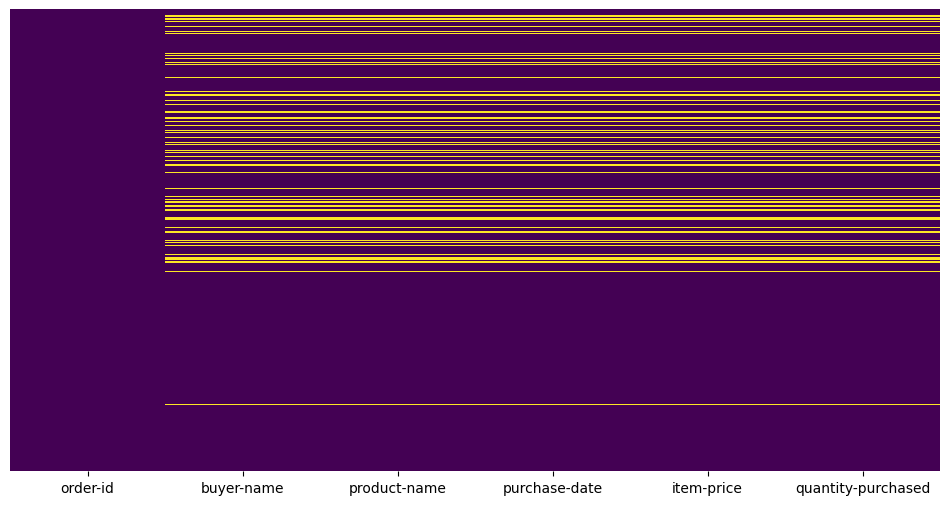

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 缺失值检测
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap="viridis")
plt.show()

### 2. 数据清洗

- 数据类型转换：统一为时间字段格式，将产品价格与产品数量的数据统一为数值型.

- 缺失值处理：识别缺失数据，删除关键字段的缺失记录。

- 异常值处理：排除重复记录，查看数据维度与检查清洗结果

In [10]:
import pandas as pd

# 加载数据
df = pd.read_csv('data.csv')

# 数据类型转换
df['purchase-date'] = pd.to_datetime(df['purchase-date'], format='%Y-%m-%dT%H:%M:%S%z',errors='coerce')
df['item-price'] = pd.to_numeric(df['item-price'], errors='coerce')
df['quantity-purchased'] = pd.to_numeric(df['quantity-purchased'], errors='coerce')

# 剔除关键字段的缺失记录
df = df.dropna(subset=['purchase-date', 'item-price', 'quantity-purchased'])

# 去重
df = df.drop_duplicates(subset=['order-id'])
df.to_csv('cleaned_data.csv', index=False)

# 检查结果
print(f"清洗后数据维度: {df.shape}\n")
print("缺失值统计:\n", df.isnull().sum())

清洗后数据维度: (1634, 6)

缺失值统计:
 order-id              0
buyer-name            0
product-name          0
purchase-date         0
item-price            0
quantity-purchased    0
dtype: int64


##　三、EDA分析

探索性数据分析（Exploratory Data Analysis, EDA）是数据分析过程中的关键步骤，旨在通过统计描述和可视化手段，深入了解数据的基本特征和潜在模式。对于本项目中的亚马逊用户订单数据，EDA主要包含以下几个方面：

- **季节趋势分析**：分析订单在不同月份的变化规律,探索季节性或促销活动对订单的影响。

- **地区市场分析**：统计不同地区的订单量和销售额,识别高价值市场及潜在增长区域。

- **商品品类分析**：掌握热销商品类别分布,分析用户类别及商品特征，揭示用户消费行为特征。

### 1. 季节趋势分析

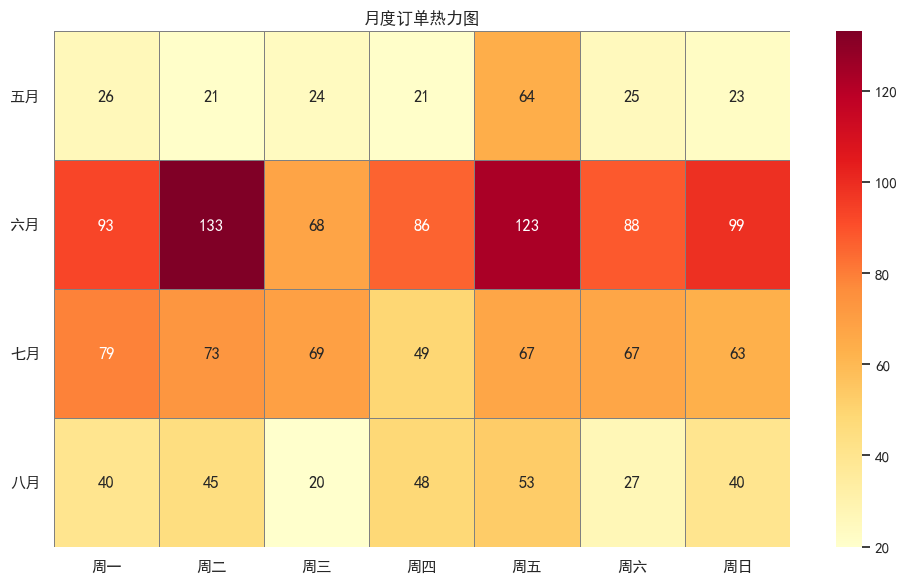

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'SimHei'

# 提取月份和星期
df = pd.read_csv('cleaned_data.csv')
df['purchase-date'] = pd.to_datetime(df['purchase-date'], errors='coerce')
df['month'] = df['purchase-date'].dt.month
df['day_of_week'] = df['purchase-date'].dt.dayofweek  # 0=周一，6=周日

# 按月份和星期统计订单数
month_day_counts = df.groupby(['month', 'day_of_week']).size().unstack(fill_value=0)

# 设置标签
week_labels = ['周一', '周二', '周三', '周四', '周五', '周六', '周日']
month_labels = {5:'五月', 6:'六月', 7:'七月', 8:'八月'}

# 绘制热力图
plt.figure(figsize=(10, 6))
sns.heatmap(month_day_counts, cmap='YlOrRd', linewidths=0.5, linecolor='gray', annot=True, fmt='d')
plt.title('月度订单热力图')
plt.xlabel('')
plt.ylabel('')

# 设置横轴纵轴标题
plt.xticks(ticks=[i + 0.5 for i in range(7)], labels=week_labels)
plt.yticks(ticks=[i + 0.5 for i in range(len(month_day_counts.index))], labels=[month_labels[m] for m in month_day_counts.index], rotation=0)
plt.tight_layout()
plt.show()

根据对不同月份与星期的时间数据进行分析与热力图的展示，得出以下订单时间上的差异与营销建议：

- **星期差异**：周五订单量最高，尤其是5月（68单）和6月（136单）表现突出，说明周五是用户购物的高峰日，周五往往是工作日中消费最高的日子，尤其在促销旺季体现明显。周三订单量普遍较低,可能受用户购物习惯影响。

- **月份差异**：6月整体订单量明显领先于其他月份，可能受促销活动、季节性因素或市场行为影响较大。7月和8月订单量有一定回落，尤其8月周三订单量显著下降（仅20单），表现出夏季服饰需求的季末衰退趋势。

- **季节营销建议**：把握销售高峰，重点推广6月，锁定高动销日，周五重点促销。7，8月提前去库存 + 降价清仓，周末开展线下、直播等互动活动提升转化率。

### 2. 地区市场分析

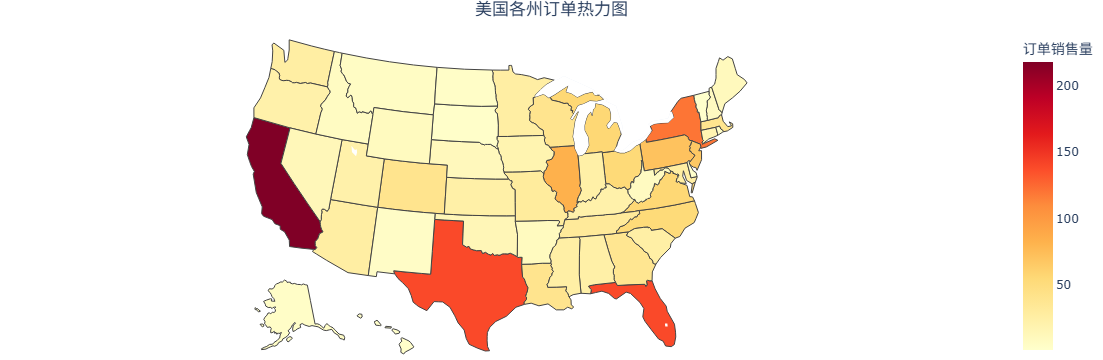

In [5]:
import pandas as pd
import plotly.express as px

df = pd.read_csv('地区市场占有率.csv')

# 绘制热力图
fig = px.choropleth(
    df,
    locations='州名简写',
    locationmode='USA-states',
    color='订单销售',
    color_continuous_scale='YlOrRd',
    scope='usa',
    labels={'订单销售': '订单销售量'},
    title='美国各州订单热力图'
)

fig.update_layout(
    geo=dict(bgcolor='rgba(0,0,0,0)'),
    margin=dict(l=0, r=0, t=30, b=0),
    title_x=0.5
)
fig.show()

根据不同地区销售量数据的分析与热力图展示，得出以下不同地区订单的特点，并提出地区市场建议：

- **高订单量州主要集中在人口大、经济活跃州**：这些州人口基数大，经济活跃，夏季炎热，符合夏装高需求特征。

- **低订单量州主要集中在中西部、山区及小州**：可能受限于人口、气候及物流因素。夏威夷虽为全年温暖地区，但订单数量仅2单，可能受限于物流、库存或电商渗透率。

- **地区市场建议**：建议重点关注高销量州进行定向广告投放与促销，可以结合气候、人口密度和现有渗透率，进一步挖掘潜力市场。而低销量州可分析物流成本、配送服务、广告覆盖等因素，需要谨慎投入。

### 3. 商品品类分析

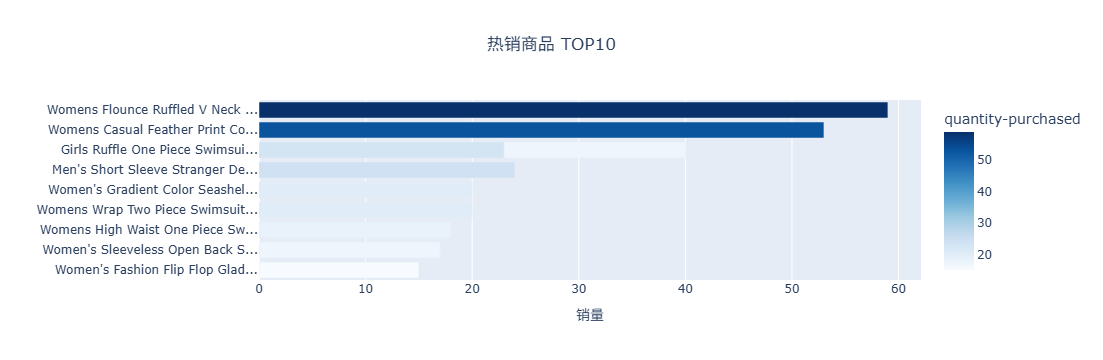

In [70]:
import plotly.express as px
import pandas as pd

df = pd.read_csv('cleaned_data.csv')

# 数据聚合
product_sales = (
    df.groupby('product-name')['quantity-purchased']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# 增加简短名称字段（最多 30 个字符）
product_sales['short_name'] = product_sales['product-name'].apply(lambda x: x[:30] + '...' if len(x) > 10 else x)

# 绘制柱状图
fig = px.bar(
    product_sales,
    x='quantity-purchased',
    y='short_name',
    orientation='h',
    title='热销商品 TOP10',
    color='quantity-purchased',
    color_continuous_scale='Blues',
    hover_data={'product-name': True, 'quantity-purchased': True, 'short_name': False}
)

fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    xaxis_title='销量',
    yaxis_title='',
    font=dict(size=12),
    title_x=0.5
)
fig.show()

根据商品品类数据的分析与柱状图的展示，得出以下用户特征与商品特征，并提出相应品类运营建议：

- **用户特征**：以女性及儿童品类占主导，仅有极少数男性商品。这说明该平台的目标用户群体在服饰类消费中以女性和儿童用户为主。

- **样式特征**：畅销款式中普遍具有以下特征：荷叶边、褶皱设计露肩、开背、深 V 等设计元素与印花图案，这说明市场偏好个性化、时尚感强的款式。

- **品类运营建议**：考虑围绕高销量品类（泳装、T 恤）扩充库存，增加多样化与时尚感款式，针对高需求群体（女性、儿童）制定更精准营销活动。

## 四、RFM模型

### 1. 构建模型

RFM 模型（Recency-Frequency-Monetary）是一种经典的用户价值分析模型，通过三个维度评估用户行为和价值表现，帮助我们在海量用户中精准识别高价值用户、流失风险用户等不同群体，为后续精细化运营和营销策略提供数据支持。下面是RFM模型的指标：

- **Recency（消费间隔）**：距分析日的天数差值，越小分值越高（代表活跃）

- **Frequency（消费频率）**：下单总次数，越大分值越高（代表忠诚）

- **Monetary（消费金额）**：累计消费金额，越大分值越高（代表高价值）

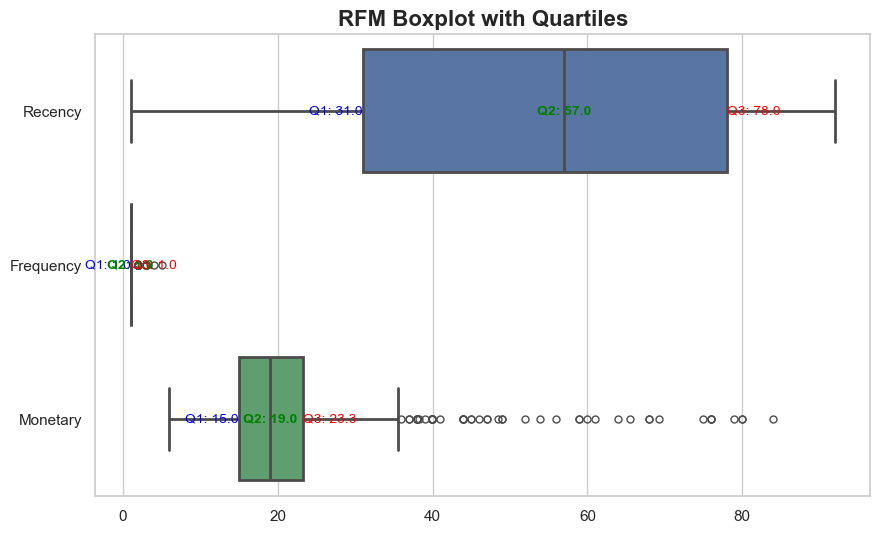

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 计算总金额
df = pd.read_csv('cleaned_data.csv')
df['amount'] = df['item-price'] * df['quantity-purchased']

# 分析日期
df['purchase-date'] = pd.to_datetime(df['purchase-date'], errors='coerce')
analysis_date = df['purchase-date'].max() + pd.Timedelta(days=1)

# 按用户聚合 R/F/M
rfm = df.groupby('buyer-name').agg({
    'purchase-date': lambda x: (analysis_date - x.max()).days,  # Recency
    'order-id': 'nunique',                                      # Frequency
    'amount': 'sum'                                             # Monetary
}).reset_index()

# 重命名列
rfm.columns = ['buyer-name', 'Recency', 'Frequency', 'Monetary']

# 绘制横向箱线图
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
palette = sns.color_palette("Set2")
ax = sns.boxplot(data=rfm[['Recency', 'Frequency', 'Monetary']], 
                 orient='h', fliersize=5, linewidth=2)
plt.title('RFM Boxplot with Quartiles', fontsize=16, fontweight='bold')

# 计算并标注四分位数
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    q1 = np.percentile(rfm[col], 25)
    q2 = np.percentile(rfm[col], 50)
    q3 = np.percentile(rfm[col], 75)
    
    # 横向箱线图，纵坐标为 i
    plt.text(q1, i, f'Q1: {q1:.1f}', color='blue', va='center', ha='right', fontsize=10)
    plt.text(q2, i, f'Q2: {q2:.1f}', color='green', va='center', ha='center', fontsize=10, fontweight='bold')
    plt.text(q3, i, f'Q3: {q3:.1f}', color='red', va='center', ha='left', fontsize=10)
plt.show()

### 2. 模型评分

从箱线图展示结果来看,数据分布比较集中，不太适合聚类模型（如K-means，GMM聚类与层次聚类等）的应用，尤其是Frequency，大部分用户都集中在1，会造成很大的误差，所以我根据REM模型指标结果，人工将各个指标分成了3档,并制定了相应的评分标准:

- **Recency**：Q1=31，Q2=57，Q3=78，大部分用户最后购买时间在第2-4个月，将购买时间差小于1个月的人群划为高分

高分（3 分）：Recency > 57（消费时间较久）

中分（2 分）：30 < Recency ≤ 57（消费时间中等）

低分（1 分）：Recency ≤ 31（消费时间较近）

- **Frequency**：Q1=Q2=Q3=1，大部分用户购买频率都为1，少部分用户购买频率大于1，直接用实际次数划分

高分（3 分）：Frequency ≥ 3（消费频率高）

中分（2 分）：Frequency = 2（消费频率中）

低分（1 分）：Frequency = 1（消费频率低）

- **Monetary**：Q1=15，Q2=19，Q3=23.3，金额集中度较高，存在较多大金额离散值，将这些离散值划分为高消费人群

高分（3 分）：Monetary ≥ 35（高消费）

中分（2 分）：15 ≤ Monetary < 35（中等消费）

低分（1 分）：Monetary < 15（低消费）

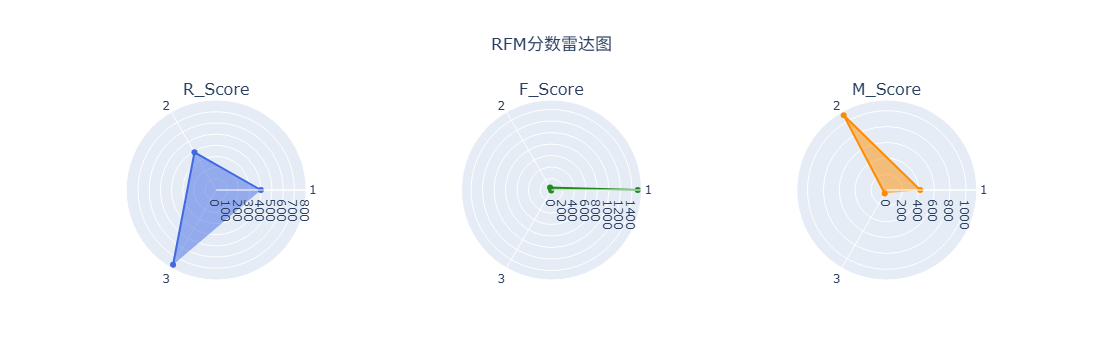

In [63]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Recency 评分
rfm['R_Score'] = rfm['Recency'].apply(lambda x: 1 if x <= 31 else (2 if x <= 57 else 3))

# Frequency 评分
rfm['F_Score'] = rfm['Frequency'].apply(lambda x: 3 if x >= 3 else (2 if x == 2 else 1))

# Monetary 评分
rfm['M_Score'] = rfm['Monetary'].apply(lambda x: 3 if x >= 35 else (2 if x >= 15 else 1))

# R_counts = count_scores(rfm, 'R_Score')
# F_counts = count_scores(rfm, 'F_Score')
# M_counts = count_scores(rfm, 'M_Score')

# 获取 RFM 分数对应的用户数量
categories = ['1', '2', '3']
scores = ['R_Score', 'F_Score', 'M_Score']
colors = ['royalblue', 'forestgreen', 'darkorange']
titles = ['R_Score', 'F_Score', 'M_Score']

# 创建 3 个独立的子图
fig = make_subplots(rows=1, cols=3, subplot_titles=titles, specs=[[{'type': 'polar'}] * 3])

# 为每个 RFM 分数创建雷达图
for i, score in enumerate(scores):
    counts = count_scores(rfm, score)
    values = [counts.get(1, 0), counts.get(2, 0), counts.get(3, 0)]
    
    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories,
        fill='toself',
        name=titles[i],
        line=dict(color=colors[i])
    ), row=1, col=i+1)

fig.update_layout(
    title="RFM分数雷达图",
    title_x=0.5,
    showlegend=False
)
fig.show()

针对不同RFM分数的人群分布与雷达图的展示,可以得出一下结果:

- **R_Score**：当前平台以高活跃用户为主，超过一半的用户近期有过购买行为，店铺整体用户活跃度较好,需要继续保持。
  
- **F_Score**：绝大多数用户为一次性购买用户，复购率偏低，需要重点关注提升用户复购、培养忠诚用户的策略。

- **M_Score**：用户消费金额集中在中等消费档次，高消费用户占比较小，可考虑制定高客单价用户培育或专属优惠策略。

### 3. 用户分群

考虑到当前数据为Amazon店铺订单数据，主要用于支持营销运营，所以以R_Score作为主线是最合理的选择。它能直观反映用户当前活跃度，更容易再次转化，并能快速指导实际行动。而且根据数据特征，不同R_Score用户比例比较适中，因此以R_Score为主要标准，将用户划分为以下三类重点人群 + 其他用户：

- **高价值用户**：R_Score = 1 且 (F_Score = 3 或 M_Score = 3)

- **潜力用户**：R_Score = 1 且 (F_Score = 2 或 M_Score = 2)

- **流失风险用户**：R_Score = 3

- **其他用户**：不满足以上条件的用户

In [110]:
from dash import dcc, html
import plotly.express as px
import pandas as pd
import dash_bootstrap_components as dbc

# 定义分群函数
def user_segment(row):
    if row['R_Score'] == 1 and (row['F_Score'] == 3 or row['M_Score'] == 3):
        return '高价值用户'
    elif row['R_Score'] == 1 and (row['F_Score'] == 2 or row['M_Score'] == 2):
        return '潜力用户'
    elif row['R_Score'] == 3:
        return '流失风险用户'
    else:
        return '其他用户'

rfm['User_Segment'] = rfm.apply(user_segment, axis=1)

# 创建散点图
fig = px.scatter(rfm, 
                 x='Recency', y='Frequency', 
                 size='Monetary', 
                 color='User_Segment', 
                 hover_data=['Recency', 'Frequency', 'Monetary'],
                 labels={'Recency': 'Recency', 'Frequency': 'Frequency', 'Monetary': 'Monetary'}
)

# 初始化 Dash 应用
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# 创建仪表盘布局
app.layout = html.Div([  

    # 标题居中
    html.H1("RFM用户分群仪表盘", style={'text-align': 'center', 'margin-top': '20px'}),
    
    # 用户选择框
    dbc.Row([
        dbc.Col([
            dcc.Dropdown(
                id='user-segment-dropdown',
                options=[{'label': segment, 'value': segment} for segment in rfm['User_Segment'].unique()],
                multi=True,
                value=rfm['User_Segment'].unique().tolist(),
                style={'width': '50%'}
            )
        ], width=12), 
    ], style={'text-align': 'center'}),  

    # 散点图
    dbc.Row([
        dbc.Col([
            dcc.Graph(
                id='rfm-scatter',
                figure=fig
            )
        ], width=12)
    ]),
])

# 设置回调
@app.callback(
    dash.dependencies.Output('rfm-scatter', 'figure'),
    [dash.dependencies.Input('user-segment-dropdown', 'value')]
 )
def update_scatter(selected_segments):
    filtered_df = rfm[rfm['User_Segment'].isin(selected_segments)]
    updated_fig = px.scatter(filtered_df, 
                             x='Recency', y='Frequency', 
                             size='Monetary', 
                             color='User_Segment', 
                             hover_data=['Recency', 'Frequency', 'Monetary'],
                             labels={'Recency': 'Recency', 'Frequency': 'Frequency', 'Monetary': 'Monetary'}
    )
    return updated_fig

# 运行应用
if __name__ == '__main__':
    app.run(debug=True)

##　五、营销方案

根据RFM模型指标,评分与用户分群的结果,以及仪表盘的展示,对这四个用户群体进行深入分析,并制定精准营销方案:

- **高价值用户**（20人）:品牌的核心资产，拥有很高的忠诚度和购买力,保持他们的活跃度是提升平台长期收益的关键

定制化服务：为高价值用户提供专属服务，如VIP客户专属优惠、周年礼物等，提高客户满意度和忠诚度。

增加互动：通过专属活动、邀请参加新品发布会等方式，增强他们与品牌的情感连接。

- **潜力用户**（259人）：特征是最近活跃且具备一定的购买频率，但尚未在金额上表现出高价值，有潜力成为高价值用户，因此是营销的重点目标群体。

性化促销：通过为潜力用户定制个性化优惠（例如新品试用、限时折扣），鼓励他们增加消费金额。

优质推荐：根据用户的购买历史和兴趣，推荐他们可能感兴趣的高价值商品，提高他们的购买倾向。


- **流失风险用户**（772人):这类用户的活跃度下降，表明他们的购买频率和最近的购买行为均较弱，可能已经开始流失。

再激活策略：通过个性化推荐、折扣券、限时优惠等手段来刺激这部分用户的消费。

忠诚度计划：通过积分和奖励机制，提高流失风险用户的购买意愿，并鼓励他们保持活跃。

- **其他用户**（510人）：这类用户活跃度较一般，但没有表现出特别高的忠诚度或频繁购买的特征，需要进一步激励，以促使其增加购买频次，并提升消费金额。

增强参与感：通过定期的促销活动或会员福利，提升用户的购买频率。

优化产品体验：通过改进客户体验和售后服务，提高客户的满意度和复购率。

总而言之，根据RFM模型评估结果的营销方案，其核心原则就是：**加强高价值用户的关系**、**深挖潜力用户**、**重视流失风险用户**。通过该模型的精准分群，品牌能够更加高效地进行客户管理和营销投入，提高客户的生命周期价值，从而实现更高的市场份额和业务增长。